## Usos de los modelos
0) puede que lo predizca tan bien porque las muestras están repetidas, asi que usaremos los nuevos datos para hacer el test real (hacer el una fucion que te haga todo, 
    1) le pasas las varaibles
    2) te calcula las mtricas 
    3) con el modelo cargado te hace las prediccion y leugo ver los resultados.

### Importamos los datos

In [1]:
# read the data/2024_main_comps.xlsx
import pandas as pd
from standard_data import *
import numpy as np
import json
from sklearn.metrics import mean_absolute_error,mean_squared_error
from joblib import load

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [57]:
def preprocesado_df(file):
    """
    Function to read the data
    Delete NanN
    Compute the main matric
    Transform the categorical data
    """
    df_base = pd.read_excel(file, skiprows=3, usecols="B:O")
    df = df_base
    mask = (df[columns_to_check] != 0) & (df[columns_to_check] != "NaN")
    df = df[mask.any(axis=1)]
    
    df = df.copy()
    for columnas in columns_to_check:
        df[columnas] = pd.to_numeric(df[columnas], errors='coerce')
    df = compute_main_ratios(df)

    # Delete rows and columns that are not necesarry
    dif_of_0 = ["Total Equity","Current Liabilities","Total Debt","EBITDA"]
    for col_ in dif_of_0:
        df = df[df[col_] != 0]
    df.dropna(inplace=True)
    df = df[var_x_num+['Rating','Sector']]
    
    # Pasamos las varaibles categoricas a ordinales
    df.loc[:,'Rating_group'] = df['Rating'].map(All_rating_order_group)
    
    df.loc[:,'Sector_ordinal'] = df['Sector'].map(sectores_dic)

    with open('dicts_ratings.json', 'r') as file:
            dict_ratings = json.load(file)
    
    df.loc[:,'Rating_ordinal'] = df['Rating'].map(dict_ratings)

    with open('dicts_ratings_group.json', 'r') as file:
            dict_ratings = json.load(file)
    
    df.loc[:,'Rating_group_ordinal'] = df['Rating_group'].map(dict_ratings)
    
    # Solo las variables que necesitamos para el modelo
    df = df[['Rating_ordinal','Rating_group_ordinal'] + var_x_num + ['Sector_ordinal']]
    return df_base, df

file = 'data/2024_main_comps.xlsx'
(df_base, df) = preprocesado_df(file)

In [58]:
# count the number of nan in each column
df.isna().sum()

Rating_ordinal              897
Rating_group_ordinal        897
Net Debt to EBITDA            0
Debt to Assets                0
Current Ratio                 0
Quick Ratio                   0
Cash ratio                    0
Long Term Debt to Equity      0
Debt to Equity                0
Debt ratio                    0
Financial Leverage            0
Sector_ordinal                0
dtype: int64

In [59]:
# filter de df only if the value in the column 'Rating_ordina' is a number
df = df[df['Rating_ordinal'].notna()]
var_x = var_x_num + ['Sector_ordinal']
df.isna().sum()

Rating_ordinal              0
Rating_group_ordinal        0
Net Debt to EBITDA          0
Debt to Assets              0
Current Ratio               0
Quick Ratio                 0
Cash ratio                  0
Long Term Debt to Equity    0
Debt to Equity              0
Debt ratio                  0
Financial Leverage          0
Sector_ordinal              0
dtype: int64

In [60]:
#check if the are inf in the df
df.isin([np.inf, -np.inf]).sum()

Rating_ordinal              0
Rating_group_ordinal        0
Net Debt to EBITDA          0
Debt to Assets              0
Current Ratio               0
Quick Ratio                 0
Cash ratio                  0
Long Term Debt to Equity    0
Debt to Equity              0
Debt ratio                  0
Financial Leverage          0
Sector_ordinal              0
dtype: int64

### Ejemplo del trabajo

In [108]:
sectores_dic

{'Energy': 1,
 'Materials': 2,
 'Industrials': 3,
 'Consumer Discretionary': 4,
 'Consumer Staples': 5,
 'Health Care': 6,
 'Financials': 7,
 'Information Technology': 8,
 'Communication Services': 9,
 'Utilities': 10,
 'Real Estate': 11}

In [131]:
# read the Datos Analisis rating.xlsx from column E to CG and from row 16 to 23, no columns
df_analisis = pd.read_excel('Datos Analisis rating.xlsx', usecols="E:CG", skiprows=14, nrows=8)
df_analisis = df_analisis.transpose()
df_analisis

,0,1,2,3,4,5,6,7
Unnamed: 4,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.550996
Unnamed: 5,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.553642
Unnamed: 6,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.556288
Unnamed: 7,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.558935
Unnamed: 8,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.561581
...,...,...,...,...,...,...,...,...
Unnamed: 80,2.793622,0.527752,1.070521,1.054168,0.731967,1.186836,1.463601,2.773274
Unnamed: 81,2.825842,0.529492,1.064008,1.047754,0.727514,1.197420,1.476832,2.789151
Unnamed: 82,2.858063,0.531211,1.057574,1.041419,0.723114,1.208005,1.490063,2.805028
Unnamed: 83,2.890283,0.532912,1.051218,1.035159,0.718768,1.218590,1.503294,2.820905


In [132]:
# use the cells C6 to C13 as columns names
df_ratios_current = pd.read_excel('Datos Analisis rating.xlsx', usecols="E", skiprows=4, nrows=8)
df_ratios_current.values

array([[2.05862979],
       [0.48903221],
       [1.27040459],
       [1.2558121 ],
       [0.88795856],
       [0.90151285],
       [1.13593962],
       [2.3228319 ]])

In [133]:
# add the to the last row of the df df_analist the values in df_ratios_current
df_analisis.loc['current'] = {i:x for i,x in zip(df_analisis.columns, df_ratios_current.values.flatten())}
df_analisis

,0,1,2,3,4,5,6,7
Unnamed: 4,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.550996
Unnamed: 5,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.553642
Unnamed: 6,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.556288
Unnamed: 7,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.558935
Unnamed: 8,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.561581
...,...,...,...,...,...,...,...,...
Unnamed: 81,2.825842,0.529492,1.064008,1.047754,0.727514,1.197420,1.476832,2.789151
Unnamed: 82,2.858063,0.531211,1.057574,1.041419,0.723114,1.208005,1.490063,2.805028
Unnamed: 83,2.890283,0.532912,1.051218,1.035159,0.718768,1.218590,1.503294,2.820905
Unnamed: 84,2.922504,0.534593,1.044937,1.028975,0.714474,1.229174,1.516524,2.836782


In [134]:
# use the cells C6 to C13 as columns names
df_ratios = pd.read_excel('Datos Analisis rating.xlsx', usecols="C", skiprows=4, nrows=8)
df_ratios.values.flatten()

array(['Net debt to EBITDA', 'Debt to Assets', 'Current Ratio',
       'Quick Ratio', 'Cash Ratio', 'Long term debt to Equity',
       'Debt to Equity', 'Financial leverage'], dtype=object)

In [135]:
# make a double loop from 1200000 to 2000000 jumping 100000 and from 0 to 1 jumping 0.125
# and create a list of strings with the format "1200000_0.0"
list_ = []
for i in range(1_200_000,2_100_000,100_000):
    for j in np.arange(0,1.125,0.125):
        list_.append(str(i)+'_'+str(j))
list_.append('current')
len(list_)

82

In [136]:
# Rename the columns of df_analisis with the values in df_ratios
df_analisis.columns = df_ratios.values.flatten()
print(df_analisis.shape)
# rename the index of df_analisis with the list_
df_analisis.index = list_
df_analisis.head()

(82, 8)


,Net debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash Ratio,Long term debt to Equity,Debt to Equity,Financial leverage
1200000_0.0,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.550996
1200000_0.125,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.553642
1200000_0.25,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.556288
1200000_0.375,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.558935
1200000_0.5,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.561581


In [137]:
df_analisis['Sector_ordinal'] = sectores_dic['Industrials'] # ya que se parece más al industrial
df_analisis['Debt ratio'] = df_analisis['Financial leverage']/df_analisis['Debt to Equity']
df_analisis.head()

,Net debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash Ratio,Long term debt to Equity,Debt to Equity,Financial leverage,Sector_ordinal,Debt ratio
1200000_0.0,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.550996,3,2.037686
1200000_0.125,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.553642,3,2.039800
1200000_0.25,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.556288,3,2.041914
1200000_0.375,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.558935,3,2.044028
1200000_0.5,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.561581,3,2.046141


Comprobamos que tenemos todas las variales:

In [138]:
# rename some the columns with Net Debt to EBITDA', 'Cash ratio', 'Long Term Debt to Equity', 'Financial Leverage
df_analisis.rename(columns={'Net debt to EBITDA':'Net Debt to EBITDA',
                            'Cash Ratio':'Cash ratio',
                            'Long term debt to Equity':'Long Term Debt to Equity',
                            'Financial leverage':'Financial Leverage'}, inplace=True)

In [139]:
variables = ['Net Debt to EBITDA',
            'Debt to Assets',
            'Current Ratio',
            'Quick Ratio',
            'Cash ratio',
            'Long Term Debt to Equity',
            'Debt to Equity',
            'Debt ratio',
            'Financial Leverage',
            'Sector_ordinal']

In [140]:
set(df_analisis.columns)- set(variables),set(variables)-set(df_analisis.columns)

(set(), set())

In [141]:
df = df_analisis

### Modelo logistico

In [19]:
X = df[var_x] 
y = np.array(df['Rating_group_ordinal']) 
print(df.shape)

(753, 12)


In [20]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/logistic_model_rating_group.sav')
y_pred = model.predict(X)

In [21]:
mse = mean_squared_error(y, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 6.411686586985391
Error Absoluto Medio (MEA): 2.361221779548473


In [22]:
ratings_ = rating_order_group.copy()
ratings_.remove('D')
print('Rating in the list',set(ratings_))

with open('dicts_ratings_group.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_group_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'BB', 'B', 'BBB', 'CC', 'AA', 'AAA', 'CCC', 'A'}
Rating in our data {'BB', 'B', 'BBB', 'AA', 'AAA', 'CCC', 'A'}
Ratings not in our list {'CC'}


In [23]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7}

In [24]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 3.05 %
Number of times it predict the exact number or 1 different: 15.27 %
Number of times it predict the exact number or 2 different: 53.39 %


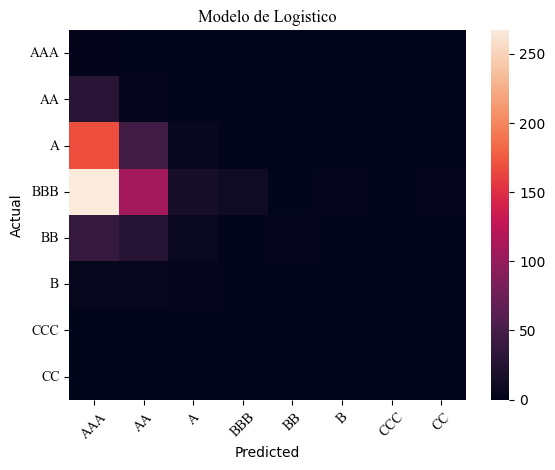

In [25]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Logistico',fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_logistic_new_data.png')
plt.show()

### Modelo regresión

In [35]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/model_polyreg_rating_group.sav')
y_pred = model.predict(X)
y_pred_rounded = np.round(y_pred, decimals=0)
y_pred_rounded= np.clip(y_pred_rounded, 0, 7)

In [36]:
mse = mean_squared_error(y, y_pred_rounded)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred_rounded)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 4.8326693227091635
Error Absoluto Medio (MEA): 1.6241699867197874


In [50]:
ratings_ = rating_order_group.copy()
ratings_.remove('D')
print('Rating in the list',set(ratings_))

with open('dicts_ratings.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_group_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'BB', 'B', 'BBB', 'CC', 'AA', 'AAA', 'CCC', 'A'}
Rating in our data {'A+', 'AA-', 'AA', 'AAA', 'AA+', 'A-', 'A'}
Ratings not in our list {'B', 'BBB', 'CC', 'BB', 'CCC'}


In [51]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 0.0 %
Number of times it predict the exact number or 1 different: 43.96 %
Number of times it predict the exact number or 2 different: 67.33 %


In [56]:
y_pred_rounded = np.round(y_pred, decimals=0)
y_pred_rounded= np.clip(y_pred_rounded, 0, 7)
print(set(y_pred_rounded))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


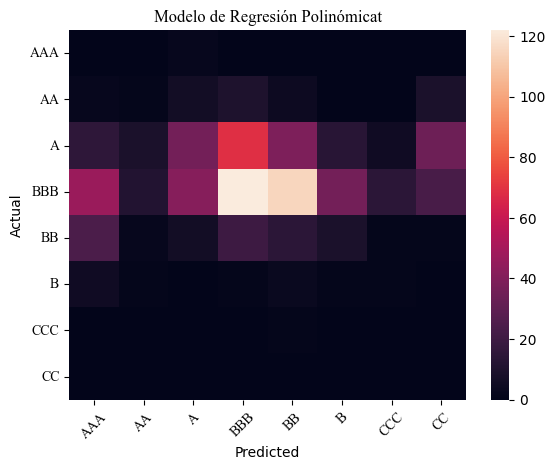

In [57]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred_rounded)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Regresión Polinómicat',fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_polreg_new_data.png')
plt.show()

### Modelo de ML

In [9]:
X = df[var_x] 
y = np.array(df['Rating_ordinal']) 

In [10]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/rf_model_rating.pkl')
y_pred = model.predict(X)

In [11]:
mse = mean_squared_error(y, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 7.604249667994688
Error Absoluto Medio (MEA): 1.5590969455511288


In [13]:
ratings_ = All_rating_order.copy()
ratings_.remove('D')
ratings_.remove('SD')
print('Rating in the list',set(ratings_))

with open('dicts_ratings.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'BB-', 'B', 'BBB', 'BBB+', 'BBB-', 'AA', 'BB+', 'A+', 'CCC-', 'BB', 'CCC+', 'AA+', 'A', 'B-', 'CC', 'AAA', 'AA-', 'B+', 'A-', 'CCC'}
Rating in our data {'A+', 'B-', 'BB', 'CCC', 'AA-', 'BB-', 'B', 'B+', 'BBB', 'BBB+', 'BBB-', 'AA', 'AAA', 'AA+', 'A-', 'BB+', 'A'}
Ratings not in our list {'CCC-', 'CCC+', 'CC'}


In [14]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [15]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 54.32 %
Number of times it predict the exact number or 1 different: 64.41 %
Number of times it predict the exact number or 2 different: 74.1 %


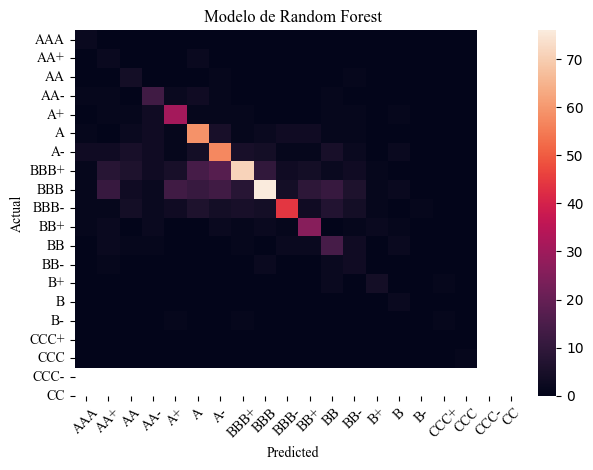

In [18]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Random Forest',fontname='Times New Roman')
plt.xlabel('Predicted',fontname='Times New Roman')
plt.ylabel('Actual',fontname='Times New Roman')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_rf_new_data.png')
plt.show()

### Hacer predicciones 

In [142]:
model = load('models/rf_model_rating.pkl')

In [143]:
# add in the last row of the df the values of the list current_ratios
X = df[var_x] 
X

,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
1200000_0.0,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.037686,2.550996,3
1200000_0.125,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.039800,2.553642,3
1200000_0.25,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.041914,2.556288,3
1200000_0.375,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.044028,2.558935,3
1200000_0.5,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.046141,2.561581,3
...,...,...,...,...,...,...,...,...,...,...
2000000_0.625,2.825842,0.529492,1.064008,1.047754,0.727514,1.197420,1.476832,1.888604,2.789151,3
2000000_0.75,2.858063,0.531211,1.057574,1.041419,0.723114,1.208005,1.490063,1.882490,2.805028,3
2000000_0.875,2.890283,0.532912,1.051218,1.035159,0.718768,1.218590,1.503294,1.876483,2.820905,3
2000000_1.0,2.922504,0.534593,1.044937,1.028975,0.714474,1.229174,1.516524,1.870581,2.836782,3


In [145]:
y_pred = model.predict(X)

In [146]:
y_pred

array([11, 11, 11,  8,  6,  6,  6,  6,  6, 11, 11, 11, 11, 11,  8, 10, 10,
       11, 13, 13, 12, 12, 12, 11, 11,  3,  4, 13, 13, 13, 13, 12, 12, 12,
       12, 11,  5,  8,  8,  8,  8,  8, 12, 12,  8,  9,  9,  5,  5,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  8,  8,  5, 10,  8,  9,  9,  8,  8,  9,
        9,  9,  9,  9,  4,  4,  9,  9,  9,  9,  9,  9,  9,  4],
      dtype=int64)

In [147]:
with open('dicts_ratings.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}

In [148]:
print([dict_ratings[i] for i in y_pred])

['BB', 'BB', 'BB', 'BBB', 'A-', 'A-', 'A-', 'A-', 'A-', 'BB', 'BB', 'BB', 'BB', 'BB', 'BBB', 'BB+', 'BB+', 'BB', 'B+', 'B+', 'BB-', 'BB-', 'BB-', 'BB', 'BB', 'AA-', 'A+', 'B+', 'B+', 'B+', 'B+', 'BB-', 'BB-', 'BB-', 'BB-', 'BB', 'A', 'BBB', 'BBB', 'BBB', 'BBB', 'BBB', 'BB-', 'BB-', 'BBB', 'BBB-', 'BBB-', 'A', 'A', 'BBB', 'BBB', 'BBB', 'BBB', 'BBB', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'BBB', 'BBB', 'A', 'BB+', 'BBB', 'BBB-', 'BBB-', 'BBB', 'BBB', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'A+', 'A+', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'BBB-', 'A+']


In [153]:
X['Estimated_rating'] = [dict_ratings[i] for i in y_pred]
X['Sector_ordinal'] = 'Industrial'
X.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17392\3294427990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Estimated_rating'] = [dict_ratings[i] for i in y_pred]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17392\3294427990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sector_ordinal'] = 'Industrial'


,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal,Estimated_rating
1200000_0.0,2.664740,0.490753,0.779621,0.761493,0.404312,1.017481,1.251908,2.037686,2.550996,Industrial,BB
1200000_0.125,2.696961,0.490244,0.745695,0.727566,0.370385,1.017481,1.251908,2.039800,2.553642,Industrial,BB
1200000_0.25,2.729181,0.489737,0.711768,0.693639,0.336458,1.017481,1.251908,2.041914,2.556288,Industrial,BB
1200000_0.375,2.761402,0.489230,0.677841,0.659713,0.302532,1.017481,1.251908,2.044028,2.558935,Industrial,BBB
1200000_0.5,2.793622,0.488725,0.643914,0.625786,0.268605,1.017481,1.251908,2.046141,2.561581,Industrial,A-


In [154]:
# export to excel the df X
X.to_excel('Analisis_rating_results.xlsx')
